# Project: YOLOv5-Based Fracture Detection Application

## Purpose of Project

In this project I would like to build a application about training a YOLOv5 model to detect fractures using a Kaggle dataset and later integrating an LLM to provide non-medical suggestions.

## Dataset Introduction

In my project, I use [XR-bones Dataset for Bone Fracture Detection](https://www.kaggle.com/datasets/japeralrashid/xr-bones-dataset-for-bone-fracture-detection/data) dataset to train my deep neural network algorithm.

The XR-bones dataset is a comprehensive collection of X-ray images designed to facilitate research and development in bone fracture detection using computer vision techniques. This dataset contains X-ray images categorized into two main classes: negative (no fracture) and positive (fracture present). The data is further organized by specific anatomical regions, ensuring a diverse and detailed representation of bone fractures.

The XR-bones dataset is ideal for developing and evaluating automated bone fracture detection algorithms. Potential applications include:

- **Medical Diagnostics**: Assisting radiologists in detecting fractures quickly and accurately.
- **Research**: Facilitating research in computer vision, deep learning, and medical image analysis.
- **Education**: Serving as a valuable resource for educational purposes in medical and technological fields.

This dataset has two sub folders:

- `images`: All medical images containing fractures and non-fractures.
- - `train`: Training images in `png` extension with `23581` photos.
- - `val`: Validation images in `png` extension with `1000` photos.
- `labels`: All labels in `txt` files that generated from YOLO model format.
- - `train`: Training labels in `txt` extension with `23581` files.
- - `val`: Validation images in `txt` extension with `1000` files.

The train folder is the main dataset for model training. In addition to the main dataset, a validation set is provided to evaluate model performance. The validation set includes 1000 images along with their corresponding labels and bounding box annotations.

Each txt file contains the following information for the respective images:

- Image ID: A unique identifier for each image.
- Class Label: Indicates whether the image is classified as negative (0) or positive (1).
- Bounding Box Coordinates: The coordinates (x_min, y_min, x_max, y_max) of the bounding box surrounding the fracture area.

## What Features Do I Have?

The dataset is divided into the following categories:

| Negative Classes (No Fracture) | Positive Classes (Fracture Present) |
| ------------------------------ | ----------------------------------- |
| XR_ELBOW_negative              | XR_ELBOW_positive                   |
| XR_FINGER_negative             | XR_FINGER_positive                  |
| XR_FOREARM_negative            | XR_FOREARM_positive                 |
| XR_HAND_negative               | XR_HAND_positive                    |
| XR_SHOULDER_negative           | XR_SHOULDER_positive                |

But the distribution of above categories is imbalance, so I decide to combine the classes into two categories:

1. Negative Classes (No Fracture)
2. Positive Classes (Fracture Present)


## Which Model Do I Choose To Train?

In this project, [YOLOv5](https://github.com/ultralytics/yolov5?tab=readme-ov-file) from [ultralytics](https://github.com/ultralytics) package was chosen as the model for fracture detection due to its ease of use for custom dataset training. YOLOv5 offers several advantages:
1. Lightweight architecture that ensures faster inference speeds, which is crucial for real-time applications. 
2. Coming with pre-trained weights, allowing for efficient transfer learning.
3. Its active community and extensive documentation provide robust support for troubleshooting and customization.

However, YOLOv5 also has its limitations. Its performance may depend heavily on the quality and quantity of the dataset, requiring careful preprocessing and balancing. Additionally, the model's simplicity might not be optimal for extremely complex datasets compared to more advanced architectures like YOLOv7 or other Transformer-based models.

The decision to start with YOLOv5 is also based on a strategy of iterative improvement. By beginning with a smaller, efficient model, we aim to establish a robust baseline for performance. If further optimization is needed to achieve the target accuracy of 90%, I can progressively transition to larger or more advanced models within the YOLO family or explore alternative architectures. This approach ensures that resources are used effectively, balancing computational efficiency with the need for model accuracy.

<img src="https://raw.githubusercontent.com/ultralytics/assets/refs/heads/main/yolo/performance-comparison.png" style="max-width: 80%; max-height: 100%;">

## What Metrics Do I Choose For Evaluation?

This is a classification problem, therefore, my expected goal is to achieve an accuracy of more than 90 through fine-tuning of the model.


## How Do I Complete This Project?

1. Download the Dataset: Ensure you have sufficient storage space and a reliable internet connection.
2. Extract the Files: Unzip the downloaded files to access the images and CSV annotations.
3. Load the Data: Use appropriate data loading techniques to read the images and annotations into your machine learning pipeline.
4. Train and Evaluate Models: Utilize the dataset to train and evaluate bone fracture detection models using techniques such as Convolutional Neural Networks (CNNs) and other machine learning algorithms.

# Import libraries

In [15]:
import cv2
import random
import shutil
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

# Exploratory Data Analysis (EDA)

First, I have to be one with my data, so I will visualize my dataset to check out the distribution of training and validation data, the format of labels for further custom training.

In this part, I will analyze the dataset from different angles, using multi-class classification and binary classification data to explore the data, and train each to compare the differences in the models.

## Calculate distribution of labels

In th first part, I will count the distribution of labels, this contains the following step:

1. Collect all the paths for images containing no fracture and fracture.

2. Load all the labels that match the image in step 1, most names of image and label are same, I need to filter the unmatched file name.

The YOLO model accepts the label format like:

<img src="https://doimages.nyc3.cdn.digitaloceanspaces.com/010AI-ML/content/images/2021/03/image-26.png" style="max-width: 80%; max-height: 100%;">

The specification for each file like following:

- One row per object
- Each row is class x_center y_center width height format.
- Box coordinates must be normalized by the dimensions of the image (i.e. have values between 0 and 1)
- Class numbers are zero-indexed (start from 0).

I have to visualize them to check out the distribution using matplotlib package.

In [2]:
# YOLODataSet
ROOT_DIR = 'YOLODataSet'
IMAGE_DIR = Path(ROOT_DIR).joinpath('images')
TRAIN_DIR = Path(IMAGE_DIR).joinpath('train')
VALID_DIR = Path(IMAGE_DIR).joinpath('val')

In [3]:
# YOLODataSet
image_paths = [imgPath for imgPath in TRAIN_DIR.glob('*.png')]

image_paths[:5]

[WindowsPath('YOLODataSet/images/train/XR_ELBOW_negative_1.png'),
 WindowsPath('YOLODataSet/images/train/XR_ELBOW_negative_10.png'),
 WindowsPath('YOLODataSet/images/train/XR_ELBOW_negative_100.png'),
 WindowsPath('YOLODataSet/images/train/XR_ELBOW_negative_1000.png'),
 WindowsPath('YOLODataSet/images/train/XR_ELBOW_negative_1001.png')]

In [4]:
def generate_label_path(image_path):
    """
    Generate the corresponding label path for a given image path.
    """
    return str(image_path).replace('images', 'labels').replace('.png', '.txt')

def read_one_path(image_paths):
    """
    Select a random image path, convert it to a label path, and attempt to read the label file.
    If an error occurs, retry with another path.
    """
    if not image_paths:
        raise ValueError("The image_paths list is empty. Cannot select a label path.")
    
    while True:
        try:
            # Select a random image path and generate the corresponding label path
            random_image_path = random.choice(image_paths)
            ex_label_path = generate_label_path(random_image_path)
            
            # Read all lines from the label file
            with open(ex_label_path, 'r') as file:
                lines = file.readlines()

            # Process and print each line
            for line in lines:
                print(line.strip().split())

            return ex_label_path  # Return the valid label path if successful
        except FileNotFoundError:
            print(f"File not found: {ex_label_path}. Trying another path.")
            break
        except Exception as e:
            print(f"An unexpected error occurred: {e}. Trying another path.")
            break


ex_label_path = read_one_path(image_paths)
print(ex_label_path)

['3', '0.513002', '0.621094', '0.274232', '0.445312']
YOLODataSet\labels\train\XR_HAND_positive_522.txt


In [5]:
def load_label_info(label_path: str, multi_label: bool=True, print_error=False) -> tuple:
    """
    Load label data from a file and convert it into a list of rectangles with their labels.

    Args:
        label_path (str): The path to the label file.
        multi_label (bool): Whether to use multi-label file.
        print_error (bool): Whether to print error.

    Returns:
        tuple: 
            - str: Overall label type ("negative" or "positive").
            - list: A list of tuples, where each tuple contains:
                - label (str): The label of the rectangle.
                - coordinates (tuple): A tuple (x_center, y_center, width, height) representing
                  the bounding box of the rectangle.
    """
    rectangles = []  # List to store rectangles with their positions
    overall_label = 0 # Default is "negative"

    try:    
        with open(label_path, 'r') as file:
            lines = file.readlines()  # Read all lines from the file
            for line in lines:
                # Parse the line into a list of float values
                info = line.strip().split()

                # The remaining values are coordinate information
                x_center, y_center, width, height = map(float, info[1:])
                
                if multi_label:
                    overall_label = int(info[0])
                else:
                    # Check if the values indicate a negative label
                    if not (x_center == 0.0 and y_center == 0.0 and width == 0.0 and height == 0.0):
                        overall_label = 1  # Set overall label to "positive"
                
                # Append the label and bounding box to the rectangles list
                rectangles.append((x_center, y_center, width, height))

        return (overall_label, rectangles)  # Return the overall label and list of labeled rectangles
    except Exception as e:
        if print_error:
            print(f"An unexpected error occurred: {e}. Trying another path.")
        else: return None


In [6]:
# Collect all the images and labels for binary classification and multi-class classification
binary_images, binary_labels = [], []
# multi_images, multi_labels = [], []

for image_path in tqdm(image_paths, ncols=100):
    label_path = str(image_path).replace('images', 'labels').replace('.png', '.txt')
    try:
        multi_label, multi_rectangle = load_label_info(label_path, multi_label=True)
        binary_label, binary_rectangle = load_label_info(label_path, multi_label=False)

        # multi images and labels
        # multi_images.append((image_path, multi_rectangle))
        # multi_labels.append(multi_label)

        # multi images and labels
        binary_images.append((image_path, binary_rectangle))
        binary_labels.append(binary_label)

    except: continue

print(f"Binary dataset: {len(binary_images)}, {len(binary_labels)}")
# print(f"Multi-class dataset: {len(multi_images)}, {len(multi_labels)}")

100%|███████████████████████████████████████████████████████| 23851/23851 [00:07<00:00, 3352.80it/s]

Binary dataset: 20501, 20501


In [7]:
binary_images[:5]

[(WindowsPath('YOLODataSet/images/train/XR_ELBOW_negative_1.png'),
  [(0.0, 0.0, 0.0, 0.0)]),
 (WindowsPath('YOLODataSet/images/train/XR_ELBOW_negative_10.png'),
  [(0.0, 0.0, 0.0, 0.0)]),
 (WindowsPath('YOLODataSet/images/train/XR_ELBOW_negative_100.png'),
  [(0.0, 0.0, 0.0, 0.0)]),
 (WindowsPath('YOLODataSet/images/train/XR_ELBOW_negative_1000.png'),
  [(0.0, 0.0, 0.0, 0.0)]),
 (WindowsPath('YOLODataSet/images/train/XR_ELBOW_negative_1001.png'),
  [(0.0, 0.0, 0.0, 0.0)])]

In [8]:
binary_labels[:5]

[0, 0, 0, 0, 0]

## Images Visualization

After loading all the images and labels I have to calculate the distribution of labels and visualize the images that contain no fracture and fracture. 

In [9]:
def label_collector(labels):
    """
    Collects and counts the occurrences of each unique label in the given list of labels.

    Parameters:
    labels (list): A list of labels (strings, integers, etc.) to be counted.

    Returns:
    dict: A dictionary where the keys are unique labels and the values are the counts of each label.
    """

    dataset = {}

    for label in tqdm(labels, ncols=100):
        # Check if the label is not already in the dataset dictionary
        if label not in dataset:
            # Initialize its count to 0 if the label is new
            dataset[label] = 0
        # Increment the count of the current label by 1
        dataset[label] += 1

    return dataset

binary_dataset = label_collector(binary_labels)
# multi_dataset = label_collector(multi_labels)

binary_dataset

100%|████████████████████████████████████████████████████| 20501/20501 [00:00<00:00, 1862610.77it/s]


{0: 14589, 1: 5912}

In [10]:
# multi_class_names = ['XR_ELBOW_positive', 'XR_FINGER_positive', 'XR_FOREARM_positive', 
#                      'XR_HAND_positive', 'XR_SHOULDER_positive', 'XR_ELBOW_negative', 
#                      'XR_FINGER_negative', 'XR_FOREARM_negative', 'XR_HAND_negative', 
#                      'XR_SHOULDER_negative']
binary_class_names = ['negative', 'positive']

def plot_bar_chart(dataset, class_names, title_rot=45):
    """
    Plots a bar chart from the dataset.

    Parameters:
        dataset (dict): A dictionary containing labels as keys and their counts as values.
        class_names (list): A list of class names corresponding to the dataset keys.

    Returns: None
    """
    # Extract keys and values
    keys = []
    values = []

    for key, value in dataset.items():
        keys.append(class_names[int(key)])
        values.append(value)

    # Create the bar chart
    plt.bar(keys, values, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.xticks(keys, rotation=title_rot)
    plt.title('Bar Chart of Dictionary Data')

    # Display the chart
    plt.show()

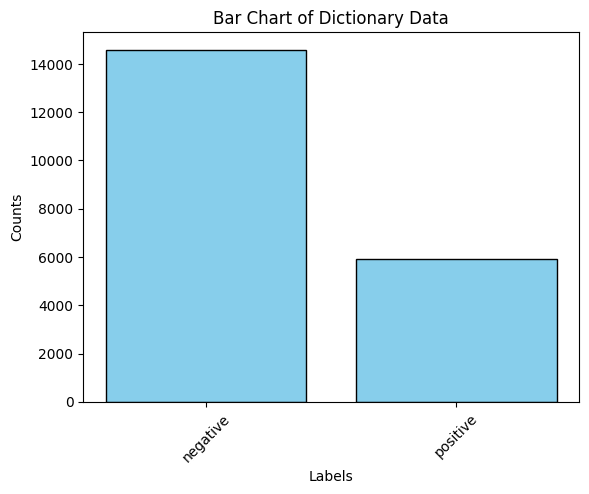

In [11]:
# labels distribution
plot_bar_chart(binary_dataset, binary_class_names)
# plot_bar_chart(multi_dataset, multi_class_names, 75)

In [12]:
def calculate_bounding_box(img_width: int, img_height: int, x_center: float, y_center: float, width: float, height: float):
    """
    Convert normalized bounding box coordinates to pixel coordinates.

    Args:
        img_width (int): The width of the image in pixels.
        img_height (int): The height of the image in pixels.
        x_center (float): The normalized x-coordinate of the box center (0 to 1).
        y_center (float): The normalized y-coordinate of the box center (0 to 1).
        width (float): The normalized width of the box (0 to 1).
        height (float): The normalized height of the box (0 to 1).

    Returns:
        tuple: Bounding box pixel coordinates as (x_min, y_min, x_max, y_max).
    """
    x_center_px = int(x_center * img_width)
    y_center_px = int(y_center * img_height)
    box_width_px = int(width * img_width)
    box_height_px = int(height * img_height)

    x_min = x_center_px - box_width_px // 2
    y_min = y_center_px - box_height_px // 2
    x_max = x_center_px + box_width_px // 2
    y_max = y_center_px + box_height_px // 2

    return x_min, y_min, x_max, y_max

def read_image(image_path: str) -> np.array:
    """Read the image using OpenCV"""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB for matplotlib

    return image

def plot_multiple_images_with_rectangles(images_selected:list, 
                                         class_names:list=['negative', 'positive'], 
                                         figsize:tuple=(15, 15), 
                                         fig_title:str='Medical Image Analysis For Fracture Detection'):
    """
    Plot multiple images with their rectangle annotations in a grid using matplotlib.
    
    Args:
        images_selected (list): A list of tuples, where each tuple contains:
            - class_id (int): The class index of the bounding box.
            - image_path (str): The file path to the image.
            - rectangles (list): A list of bounding box data, where each bounding box is a tuple:
                (x_center, y_center, width, height)), where:
                - x_center (float): The normalized x-coordinate of the bounding box center (0 to 1).
                - y_center (float): The normalized y-coordinate of the bounding box center (0 to 1).
                - width (float): The normalized width of the bounding box (0 to 1).
                - height (float): The normalized height of the bounding box (0 to 1).
        class_names (list, optional): A list of class names corresponding to the `class_id` values in the rectangles.
                                      Defaults to ['negative', 'positive'].
        figsize (tuple, optional): The size of the overall figure in inches. Defaults to (15, 15).
        fig_title (str, optional): The overall title for the entire figure. Defaults to 'Medical Image Analysis For Fracture Detection'.
    """
    # Calculate the side length of the grid (assume the number of images is a perfect square)
    side = np.sqrt(len(images_selected)).astype(np.int32)

    # Create a grid of subplots
    fig, axes = plt.subplots(side, side, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    for idx, (class_id, (image_path, rectangles)) in enumerate(images_selected):
        # Read the image using OpenCV
        image = read_image(image_path)
        img_height, img_width, _ = image.shape  # Get image dimensions

        # Draw each rectangle and its label on the image
        for (x_center, y_center, width, height) in rectangles:
            # Ensure class_id is an integer
            class_id = int(class_id)

            # Convert bounding box to pixel coordinates
            x_min, y_min, x_max, y_max = calculate_bounding_box(img_width, img_height, x_center, y_center, width, height)

            # Draw the bounding box and center point
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)  # Blue box

            # Add class label text
            class_title = class_names[class_id]
            cv2.putText(image, class_title, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                        fontScale=0.5, color=(255, 255, 255), thickness=1)
        
        # Plot the image in the current subplot
        ax = axes[idx]
        ax.imshow(image)
        ax.axis('off')  # Turn off axes for a cleaner visualization
        
        # Add a title for the subplot
        ax.set_title(f"Image {idx + 1}: {class_title}")


    # Hide any unused axes (in case the number of images is less than the grid size)
    for ax in axes[len(images_selected):]:
        ax.axis('off')

    # Add an overall title for the figure
    fig.suptitle(fig_title, fontsize=16, fontweight='bold', y=0.98)
    
    # Adjust layout for better spacing and show the figure
    # A rectangle in normalized figure coordinates into which the whole subplots area (including labels) will fit
    # left, bottom, right, top
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

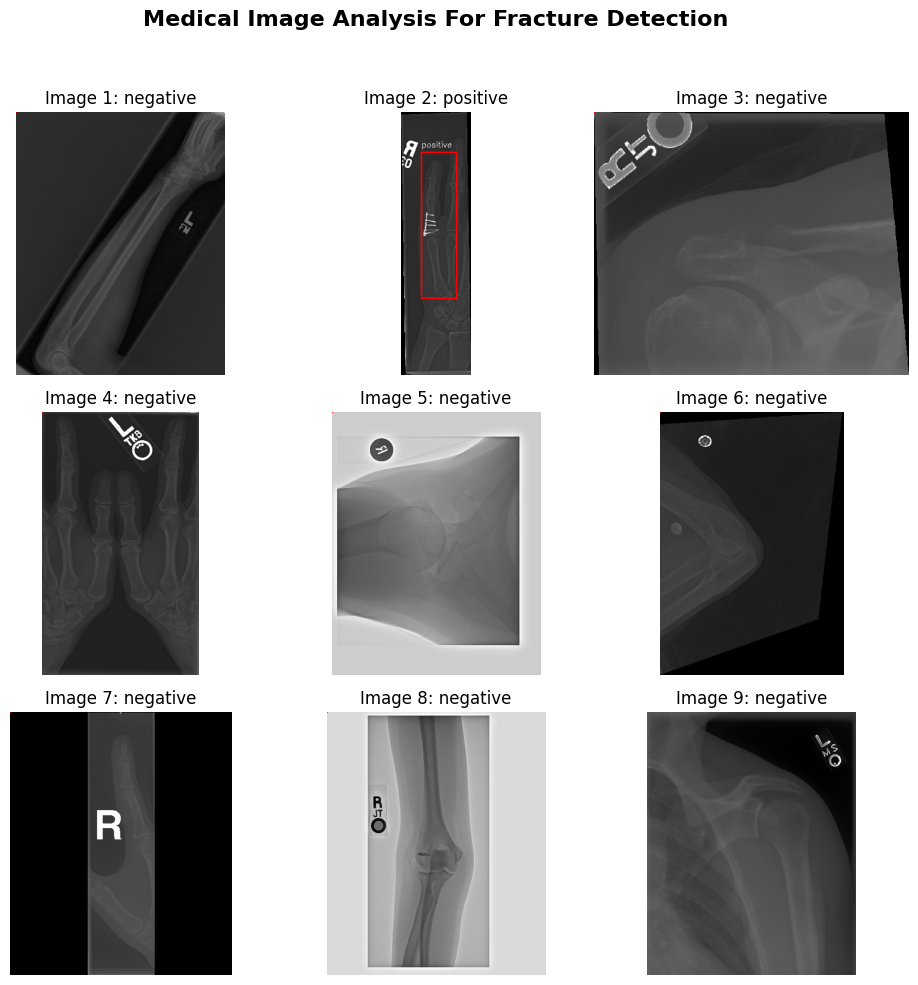

In [13]:
images_selected = random.choices(list(zip(binary_labels, binary_images)), k=9)
plot_multiple_images_with_rectangles(images_selected, binary_class_names, figsize=(10, 10))

100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2748.99it/s]


Binary dataset: 1000, 1000


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1000788.36it/s]


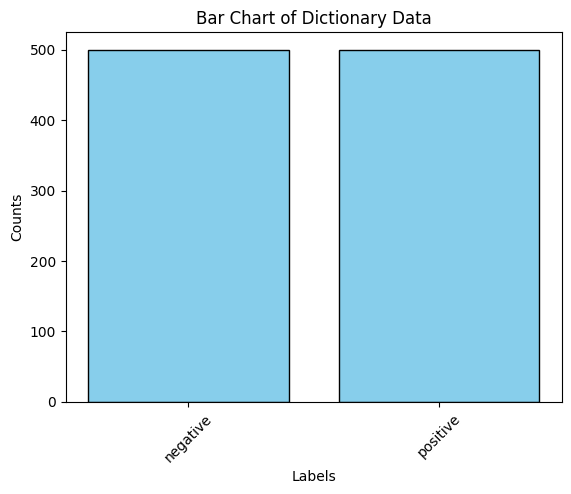

In [14]:
# Check the distribution of validation images
valid_image_paths = [imgPath for imgPath in VALID_DIR.glob('*.png')]

# Collect all the images and labels for binary classification and multi-class classification
binary_valid_images, binary_valid_labels = [], []
# multi_valid_images, multi_valid_labels = [], []

for image_path in tqdm(valid_image_paths, ncols=100):
    label_path = str(image_path).replace('images', 'labels').replace('.png', '.txt')
    try:
        multi_valid_label, multi_valid_rectangle = load_label_info(label_path, multi_label=True)
        binary_valid_label, binary_valid_rectangle = load_label_info(label_path, multi_label=False)

        # multi images and labels
        # multi_valid_images.append((image_path, multi_valid_rectangle))
        # multi_valid_labels.append(multi_valid_label)

        # multi images and labels
        binary_valid_images.append((image_path, binary_valid_rectangle))
        binary_valid_labels.append(binary_valid_label)

    except: continue

print(f"Binary dataset: {len(binary_valid_images)}, {len(binary_valid_labels)}")
# print(f"Multi-class dataset: {len(multi_valid_images)}, {len(multi_valid_labels)}")

# Collect validation label data
binary_valid_dataset = label_collector(binary_valid_labels)
# multi_valid_dataset = label_collector(multi_valid_labels)

multi_class_names = ['XR_ELBOW_positive', 'XR_FINGER_positive', 'XR_FOREARM_positive', 
                     'XR_HAND_positive', 'XR_SHOULDER_positive', 'XR_ELBOW_negative', 
                     'XR_FINGER_negative', 'XR_FOREARM_negative', 'XR_HAND_negative', 
                     'XR_SHOULDER_negative']
binary_class_names = ['negative', 'positive']

plot_bar_chart(binary_valid_dataset, binary_class_names)
# plot_bar_chart(multi_valid_dataset, multi_class_names)

## Observation

It seems the training dataset is imbalanced:

| Negative Counts | Positive Counts |
| --------------- | --------------- |
| 14589           | 5912            |

From my observation, the training dataset is imbalanced, with significantly more negative samples (14,589) than positive samples (5,912). This imbalance could cause the model to be biased toward predicting the majority class (negative), which could lead to poor performance in identifying the minority class (positive).

To address this issue, several strategies can be employed:

1. **Resampling Techniques**:
   - **Oversampling**: Increase the number of positive samples by duplicating or generating synthetic data. One popular technique for this is the **SMOTE (Synthetic Minority Over-sampling Technique)** algorithm, which generates synthetic samples by interpolating between existing positive samples.
   - **Undersampling**: Reduce the number of negative samples to match the number of positive samples. While this helps balance the dataset, it may lead to the loss of important information.

2. **Class Weighting**: Many machine learning algorithms, including those in **TensorFlow** and **Scikit-learn**, offer class weights to penalize the model more for incorrect predictions on the minority class. This can be achieved by specifying higher weights for the positive class during model training. This encourages the model to pay more attention to the minority class.

3. **Data Augmentation**: Augmenting the dataset by applying transformations (such as rotations, flips, cropping, etc.) to the positive samples can help generate additional diverse examples, especially if the positive class has fewer variations in features compared to the negative class.

4. **Evaluation Metrics**: In an imbalanced dataset, **accuracy** may not be the best evaluation metric. It's important to monitor metrics like **Precision**, **Recall**, **F1-score**, and **AUC-ROC** to get a better understanding of the model's performance across both classes. In my project, I am working with **imbalanced data** in **object detection** tasks, designing appropriate evaluation metrics becomes crucial to ensure the model's performance on both the majority and minority classes is fairly assessed. Hence I have several options to be considered:
   - **Precision**: Measures how many of the predicted positive bounding boxes are correct. It is the ratio of true positives (TP) to all predicted positives (TP + false positives (FP)).【**Precision = TP / (TP + FP)**】
   - **Recall**: Measures how many of the actual positive bounding boxes were detected. It is the ratio of true positives (TP) to all actual positives (TP + false negatives (FN)).【**Recall = TP / (TP + FN)**】
   - **F1-Score**: This metric is particularly helpful because it penalizes a model that is biased toward one of the metrics (e.g., accuracy or recall), which is common when dealing with imbalanced data.【**F1-score = 2 * (Precision * Recall) / (Precision + Recall)**】
   - **Intersection over Union (IoU)**: **IoU** measures the overlap between the predicted bounding box and the ground truth bounding box. This is essential in object detection tasks to evaluate how accurate the bounding box predictions are. For imbalanced datasets, focusing on a reasonable IoU threshold is important.【**IoU = Area of Overlap / Area of Union**】
   - **Average Precision (AP) and Mean Average Precision (mAP)**: **Average Precision (AP)** is an evaluation metric that considers both precision and recall, and it is computed for each class by plotting the precision-recall curve 【**AP = ∫ (Precision * Recall) d(Recall)**】. **mAP** is the mean of the AP scores across all classes.
   - **Weighted Average Precision (WAP)**: To address class imbalance more effectively, one of all the options is **weighted average precision**, where the AP score for each class is weighted based on the class frequency or importance. This helps in giving more importance to the minority classes that may otherwise be overshadowed by the majority class.【**WAP = Σ (AP_class * class_weight) / total_weight**】

By implementing one or more of these methods, I can ensure that the model performs better on both the negative and positive classes, reducing bias toward the majority class and improving overall classification performance. 

# Prepare Training and Label Data

According to the [ultralytics tutorial](https://docs.ultralytics.com/zh/yolov5/tutorials/train_custom_data/#how-do-i-convert-my-annotated-data-to-yolov5-format), and I observe that not all the images are available with their label files. However, I have to create a few paths for custom training like followings:

```bash
Image_path: 
YOLODataSet/dataset/images/train
YOLODataSet/dataset/images/val

Label_path:
YOLODataSet/dataset/labels/train
YOLODataSet/dataset/labels/val
```

After that, I also create a `YAML` file as data config file for model training parameters, the following parameters have to be defined in a data config file:

- train, and val: Locations of train, and validation images.
- nc: Number of classes in the dataset.
- names: Names of the classes in the dataset. The index of the classes in this list would be used as an identifier for the class names in the code.

```bash
train: ../Path/to/train/images/
val:  ../Path/to/val/images

nc: Number of classes

names: [class_names...]
```

other source: [1](https://www.digitalocean.com/community/tutorials/train-yolov5-custom-data#convert-the-annotations-into-the-yolo-v5-format), [2](https://docs.ultralytics.com/zh/yolov5/tutorials/train_custom_data/#4-train)

## Create Dataset Folder

In this part I will create all the dataset path for further training.

In [15]:
def create_dataset_path(root_dir: str=ROOT_DIR):
    """
    Create and ensure the existence of dataset directory paths for training and validation images and labels.

    This function generates paths for storing training and validation data (images and labels) within a 
    structured directory under the specified root directory. If the directories do not already exist, 
    they are created.

    Args:
        root_dir (str): The root directory where the dataset folders will be created. Defaults to ROOT_DIR.

    Returns:
        list[Path]: A list of Path objects representing the created or existing dataset paths. The order of paths is:
            - Training images path
            - Validation images path
            - Training labels path
            - Validation labels path
    """
    image_train_data_path = Path(root_dir).joinpath('dataset', 'images', 'train')
    image_val_data_path = Path(root_dir).joinpath('dataset', 'images', 'val')
    label_train_data_path = Path(root_dir).joinpath('dataset', 'labels', 'train')
    label_val_data_path = Path(root_dir).joinpath('dataset', 'labels', 'val')
    dataset_paths = [image_train_data_path, image_val_data_path, label_train_data_path, label_val_data_path]

    for ds_path in dataset_paths:
        if not ds_path.exists():
            ds_path.mkdir(parents=True)
    
    return dataset_paths

def get_dataset_path(img_path: Path, paths_mapping: dict) -> tuple:
    """
    Adapter function to get the destination paths based on the image path string.
    
    Args:
        img_path (Path): The Path representation of the image path.
        paths_mapping (dict): A dictionary mapping keywords to their respective paths.
        
    Returns:
        tuple: A tuple containing destination image and label paths.
        
    Raises:
        ValueError: If the path string does not match any known key.
    """
    img_path_string = str(img_path)
    for key, (image_path, label_path) in paths_mapping.items():
        if key in img_path_string:
            return image_path, label_path
        
    raise ValueError('Invalid dataset path, must contain train or val!')


In [16]:
# Create a dataset path
image_train_data_path, image_val_data_path, \
    label_train_data_path, label_val_data_path = create_dataset_path(root_dir=ROOT_DIR)

image_train_data_path, image_val_data_path, label_train_data_path, label_val_data_path

(WindowsPath('YOLODataSet/dataset/images/train'),
 WindowsPath('YOLODataSet/dataset/images/val'),
 WindowsPath('YOLODataSet/dataset/labels/train'),
 WindowsPath('YOLODataSet/dataset/labels/val'))

In [17]:
# Define the mapping of keywords to destination paths
paths_mapping = {
    'train': (image_train_data_path, label_train_data_path),
    'val': (image_val_data_path, label_val_data_path)
}

# Allocate image and label path with a adapter
rand_path = random.choice(binary_images)
dest_image_data_path, dest_label_data_path = get_dataset_path(rand_path, paths_mapping)

rand_path, dest_image_data_path, dest_label_data_path

((WindowsPath('YOLODataSet/images/train/XR_FOREARM_negative_870.png'),
  [(0.0, 0.0, 0.0, 0.0)]),
 WindowsPath('YOLODataSet/dataset/images/train'),
 WindowsPath('YOLODataSet/dataset/labels/train'))

## Process Imbalanced Data

In the previous part I observed that the training dataset is imbalanced, with significantly more negative samples (14,589) than positive samples (5,912). However I decide to employ 2 strategies to figure out:

- For `negative samples`, I would lke to apply **undersampling** technique to reduce the number of negative samples to `10,000` images, this number is enough to fine-tune the `YOLO` model.

- For `positive samples`, I would lke to apply **data augmentation** to augment the dataset by applying `horizontally flips` to the positive samples util `10,000` images. This can help generate additional diverse examples, especially if the positive class has fewer variations in features compared to the negative class.

In [18]:
negative_images = list(filter(lambda path: 'negative' in str(path), binary_images))
positive_images = list(filter(lambda path: 'positive' in str(path), binary_images))

In [19]:
def flip_image_with_bbox(image_array: np.array, bbox: tuple) -> tuple:
    """
    Horizontally flip an image and adjust the bounding box coordinates.

    Args:
        image_array (np.array): Numpy array of the input image.
        bbox (tuple): Bounding box coordinates in the format (x_center, y_center, width, height).

    Returns:
        tuple: Flipped image and adjusted bounding box coordinates.
    """
    # Horizontally flip the image
    flipped_image = cv2.flip(image_array, 1)

    # Get the original bounding box coordinates
    x_center, y_center, width, height = bbox

    # Calculate the new bounding box coordinates
    new_x_center = round((1. - x_center), 6)

    new_bbox = (new_x_center, y_center, width, height)
    
    return flipped_image, new_bbox

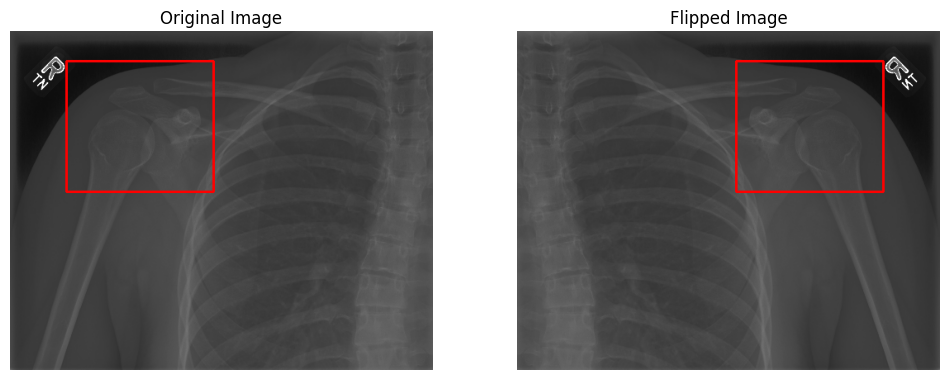

In [20]:
def flip_and_plot_image_with_rectangles(image_path: str, bbox: tuple):
    """
    Flip an image horizontally and adjust the bounding box coordinates. 
    Also plot the original and flipped images with bounding boxes.

    Args:
        image_path (str): Path to the input image.
        bbox (tuple): Bounding box coordinates in the format (x_center, y_center, width, height).

    Returns:
        tuple: Flipped image and adjusted bounding box coordinates.
    """
    # Read the image using OpenCV
    image = read_image(image_path)
    img_height, img_width, _ = image.shape
    x_center, y_center, width, height = bbox

    # Horizontally flip the image using OpenCV
    flipped_image, new_bbox = flip_image_with_bbox(image, bbox)
    new_x_center, new_y_center, new_width, new_height = new_bbox

    # Plot the original image with the bounding box
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image
    # Convert bounding box to pixel coordinates
    x_min, y_min, x_max, y_max = calculate_bounding_box(img_width, img_height, x_center, y_center, width, height)

    # Draw the bounding box and center point
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)  # Blue box
    
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Flipped imag
    # Convert bounding box to pixel coordinates
    new_x_min, new_y_min, new_x_max, new_y_max = calculate_bounding_box(img_width, img_height, new_x_center, new_y_center, new_width, new_height)

    # Draw the bounding box and center point
    cv2.rectangle(flipped_image, (new_x_min, new_y_min), (new_x_max, new_y_max), color=(255, 0, 0), thickness=2)  # Blue box

    axs[1].imshow(flipped_image)
    axs[1].set_title('Flipped Image')
    axs[1].axis('off')

    plt.show()

positive_img_selected = random.choice(positive_images)
positive_img_path, positive_bbox = positive_img_selected
flip_and_plot_image_with_rectangles(str(positive_img_path), positive_bbox[0])

## Move Images And Labels To Dataset

In this part I will combine the previous functions together to create a pipeline containing:

1. Create a dataset path

2. Sample and read image paths

3. Employ data augmentation

4. Move selected images and labels to the dataset created on step 1

In [22]:
def move_image(src_path: Path, dest_path: Path, mode: str='copy'):
    """
    Move or copy an image from the source path to the destination path based on the mode.

    Args:
        src_path (Path): The source path of the image.
        dest_path (Path): The destination directory path.
        mode (str): The mode of operation, either 'copy' to copy the file or any other value to move the file. Default is 'copy'.

    Returns:
        Path: The destination file path of the moved or copied image.
    """
    try:
        # Get the file name and generate the destination path
        dest_file_path = dest_path.joinpath(src_path.name)
        
        # Move or copy the file based on the mode
        if mode == 'copy':
            shutil.copy(str(src_path), str(dest_file_path))
        else:
            shutil.move(str(src_path), str(dest_file_path))
        
        return dest_file_path

    except Exception as e:
        # Print an error message if an exception occurs
        print(f"An error occurred: {e}")

def create_label_content_with_file(src_path: Path, img_cls: str, save_path: str): 
    """
    Creates a new label content by modifying the class label of an existing file and saves it to a new location.

    Args:
        src_path (Path): The source path of the label file.
        img_cls (str): The new image classification label to prepend.
        save_path (str): The path where the modified label content should be saved.

    Returns:
        str: The modified label content.
    """
    # Open the source file and read its content
    with src_path.open('r') as file:
        content = file.read()
    
    # Modify the content by prepending the new class label
    content = img_cls + content[1:]

    # Save the modified content to the new path
    with open(str(save_path), mode='w') as file:
        file.write(content)

    return content

def create_label(src_path: Path, dest_path: Path, img_cls: str):
    """
    Creates a new label file with the specified class label and saves it to the destination path.

    Args:
        src_path (Path): The source path of the original label file.
        dest_path (Path): The destination directory path where the new label file will be saved.
        img_cls (str): The new image classification label to be added to the label content.

    Returns:
        Path: The destination file path of the created label.
    """
    try:
        # Get the file name and generate the destination path
        dest_file_path = dest_path.joinpath(src_path.name)        

        # Create a new label file with modified content
        _ = create_label_content_with_file(src_path, img_cls, save_path=dest_file_path)
        
        return dest_file_path

    except Exception as e:
        print(f"An error occurred: {e}")

def create_label_content_with_bbox(img_cls: int, bbox: tuple):
    """
    Create a string representation of label content for an image.

    Args:
        img_cls (int): The image classification label.
        bbox (tuple): A tuple containing the bounding box coordinates (x_center, y_center, width, height).

    Returns:
        str: A space-separated string of the label content (img_cls, x_center, y_center, width, height).
    """
    
    # Unpack the bounding box coordinates
    x_center, y_center, width, height = bbox
    
    # Create a tuple with the image classification and bounding box information
    content = (img_cls, x_center, y_center, width, height)
    
    # Convert all elements in the content tuple to strings
    content_str = tuple(map(str, content))
    
    # Join the string elements with a space
    content_txt = ' '.join(content_str)
    
    return content_txt

def generate_label_content(img_cls: str, bbox: tuple, save_path: str):
    """
    Generates label content for an image with specified bounding box coordinates and saves it to a file.

    Args:
        img_cls (str): The image classification label.
        bbox (tuple): A tuple containing the bounding box coordinates (x_center, y_center, width, height).
        save_path (str): The path where the label content should be saved.

    Returns:
        bool: True if the label content was successfully generated and saved.
    """
    content = create_label_content_with_bbox(img_cls=img_cls, bbox=bbox)

    # Write the label content to the specified file
    with open(str(save_path), mode='w') as file:
        file.write(content)

    return True


In [25]:
def move_data_to_dataset(root_dir: str, 
                         image_data: list, label_data: list, 
                         train_data=False, 
                         down_samples: int=10_000, 
                         data_aug=False) -> bool:
    """ 
    Move image and label data to dataset folders, with optional data augmentation. 
    
    Args: 
        root_dir (str): The root directory path where the dataset folders will be created. 
        image_data (list): A list of tuples containing image paths and positions. 
        label_data (list): A list of corresponding labels for the images. 
        train_data (bool): Whether the data is for training. Default is False. 
        down_samples (int): The number of negative samples to select. Default is 10,000. 
        data_aug (bool): Whether to perform data augmentation. Default is False. 
    
    Returns: 
        tuple: 
            A tuple containing the lists of new image paths and their corresponding labels. 
    """
    
    # Create a dataset path
    image_train_data_path, image_val_data_path, \
    label_train_data_path, label_val_data_path = create_dataset_path(root_dir=root_dir)
    
    if train_data:
        # Separate negative and positive images
        negative_images = list(filter(lambda path: 'negative' in str(path[0]), image_data))
        positive_images = list(filter(lambda path: 'positive' in str(path[0]), image_data))

        # Define the number of positive samples as half of the negative samples 
        num_positive_samples = int(down_samples//2)
        if len(negative_images) < down_samples or len(positive_images) < num_positive_samples: 
            print("Insufficient samples for the selection process") 
            return False

        # Select negative and positive images
        negative_images_selected = random.sample(negative_images, k=down_samples)
        positive_images_selected = random.sample(positive_images, k=num_positive_samples)

        # Create final image data
        final_image_data = negative_images_selected + positive_images_selected
        final_label_data = [0]*down_samples + [1]*num_positive_samples
        image_data_for_move = list(zip(final_label_data, final_image_data))
    else:
        image_data_for_move = list(zip(label_data, image_data))

    # Define the mapping of keywords to destination paths
    paths_mapping = {
        'train': (image_train_data_path, label_train_data_path),
        'val': (image_val_data_path, label_val_data_path)
    }

    new_image_data = []
    new_label_data = []
    print('Start moving data...')
    for img_cls, (img_path, pos_list) in tqdm(image_data_for_move, ncols=100):

        # Allocate image and label path with a adapter
        dest_image_data_path, dest_label_data_path = get_dataset_path(img_path, paths_mapping)
        
        # Move images to new dataset
        dest_image_path = move_image(src_path=img_path, dest_path=dest_image_data_path)

        # Move labels to new  dataset
        labelPath = Path(str(img_path).replace('images', 'labels').replace('.png', '.txt'))
        _ = create_label(src_path=labelPath, dest_path=dest_label_data_path, img_cls=str(img_cls))

        new_image_data.append((dest_image_path, pos_list))
        new_label_data.append(img_cls)

    # Data augmentation
    if data_aug:
        print('Start data augmentation...')
        positive_images_aug_selected = list(filter(lambda path: 'positive' in str(path[0]), new_image_data))
        for img_path, pos_list in tqdm(positive_images_aug_selected,  ncols=100):
            bbox = pos_list[0]
            image = read_image(str(img_path)) # read image
            flipped_image, new_bbox = flip_image_with_bbox(image, bbox) # flip image

            # generate new image path
            parent_dir = img_path.parent
            original_stem = img_path.stem
            suffix = img_path.suffix
            flipped_img_path = parent_dir / (original_stem + '_aug' + suffix)

            # save augmented image
            cv2.imwrite(flipped_img_path, flipped_image)

            # Move labels to new  dataset
            flipped_img_label_path = Path(str(flipped_img_path).replace('images', 'labels').replace('.png', '.txt'))
            _ = generate_label_content(img_cls='1', bbox=new_bbox, save_path=flipped_img_label_path)
            
            new_image_data.append((flipped_img_path, pos_list))
            new_label_data.append(1)

    return new_image_data, new_label_data

In [28]:
# Training data moving
new_train_image_data, new_train_label_data = move_data_to_dataset(root_dir=ROOT_DIR, \
                                                                  image_data=binary_images, label_data=binary_labels, \
                                                                  train_data=True, down_samples=10_000, data_aug=True)

Start moving data...


100%|████████████████████████████████████████████████████████| 15000/15000 [00:46<00:00, 320.95it/s]


Start data augmentation...


100%|███████████████████████████████████████████████████████████| 5000/5000 [01:00<00:00, 82.28it/s]


In [29]:
# Validation data moving
new_valid_image_data, new_valid_label_data = move_data_to_dataset(root_dir=ROOT_DIR, \
                                                                  image_data=binary_valid_images, label_data=binary_valid_labels, \
                                                                  train_data=False, data_aug=False)

Start moving data...


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.35it/s]


# Train YOLO models

## Load Dataset

In [16]:
# YOLODataSet
IMAGE_DIR = 'YOLODataSet/dataset/images'
TRAIN_DIR = Path(IMAGE_DIR).joinpath('train')
VALID_DIR = Path(IMAGE_DIR).joinpath('val')

In [2]:
# import torch
# dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\User/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\User/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\User/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
